## Snap observations to model grid

In [101]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [102]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut
%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [103]:
horse = False #turn horse to True to run extraction


### Look at data given to JG by BBC and plot without gridding

In [104]:
df = pd.read_csv('forjoewithtime.csv')
df.head()



,year,month,longitude,latitude,depth,POCflux,PICflux,PSiFlux
0,1991,7,179.0,58.0,3137,7.32,2.37,51.86
1,1991,8,179.0,58.0,3137,2.64,1.87,16.43
2,1991,9,179.0,58.0,3137,2.60,1.90,14.56
3,1991,9,179.0,58.0,3137,7.62,6.39,45.23
4,1991,10,179.0,58.0,3137,5.60,9.03,36.55


In [105]:
## lons and lats as np array for simplicity
lons = np.array(df['longitude'])
lats = np.array(df['latitude'])
depths = np.array(df['depth'])

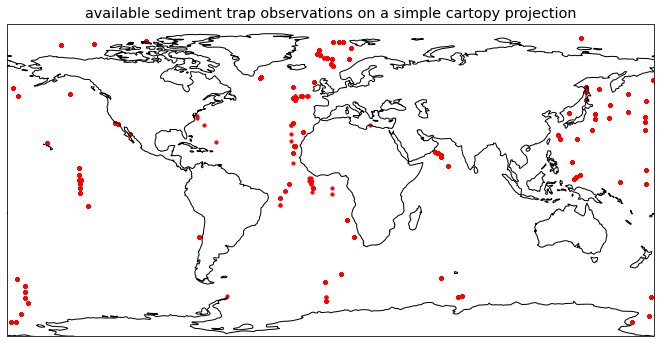

In [106]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fact = 0.8
tfig = plt.figure(figsize=[14.5*fact, 14.5*fact])
ax = plt.axes(projection=ccrs.PlateCarree())
mesh = ax.scatter(lons, lats, s = 10, c = 'red',
                 transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('available sediment trap observations on a simple cartopy projection')
plt.show()

## haversine-based code for assigning model lats and lons

In [107]:
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points
    on a sphere from their longitudes and latitudes.
    Reference: http://www.movable-type.co.uk/scripts/latlong.html
    :arg lon1: Longitude of point 1.
    :type lon1: float or :py:class:`numpy.ndarray`
    :arg lat1: Latitude of point 1.
    :type lat1: float or :py:class:`numpy.ndarray`
    :arg lon2: Longitude of point 2.
    :type lon2: float or :py:class:`numpy.ndarray`
    :arg lat2: Latitude of point 2.
    :type lat2: float or :py:class:`numpy.ndarray`
    :returns: Great-circle distance between two points in km
    :rtype: float or :py:class:`numpy.ndarray`
    code taken by TJ from SalishSeaCast group
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def find_closest(lon1, lat1):
    w = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_1ASA/ORCA2_1m_20500101_20501231_ptrc_T.nc')
    lats = (w['nav_lat'][:])
    lons = w['nav_lon'][:]
    km = haversine(lon1, lat1, lons, lats)
    q = (np.where(km == np.min(km)))
    tY = q[0][0]
    tX = q[1][0]

    return tY, tX

lon1 = -20
lat1 = 20
print(f'test lon: {lon1}, test lat {lat1}')
tY, tX = find_closest(lon1, lat1)
print(f'returns x: {tX}, y {tY}')

test lon: -20, test lat 20
returns x: 131, y 91


## assign model x and ys

In [108]:

if horse:
    mod_X = np.zeros_like(lons)
    mod_Y = np.zeros_like(lons)

    for i in range(0, len(mod_X)):
        if i%1000 == 0:
            print(i) # just a counter for progress
        mod_Y[i], mod_X[i] = find_closest(lons[i], lats[i])

## an overly-elaborate depth profile diagram that shows the edges of the levels

Text(0.5, 0.98, 'make sure we know where our z-cells are')

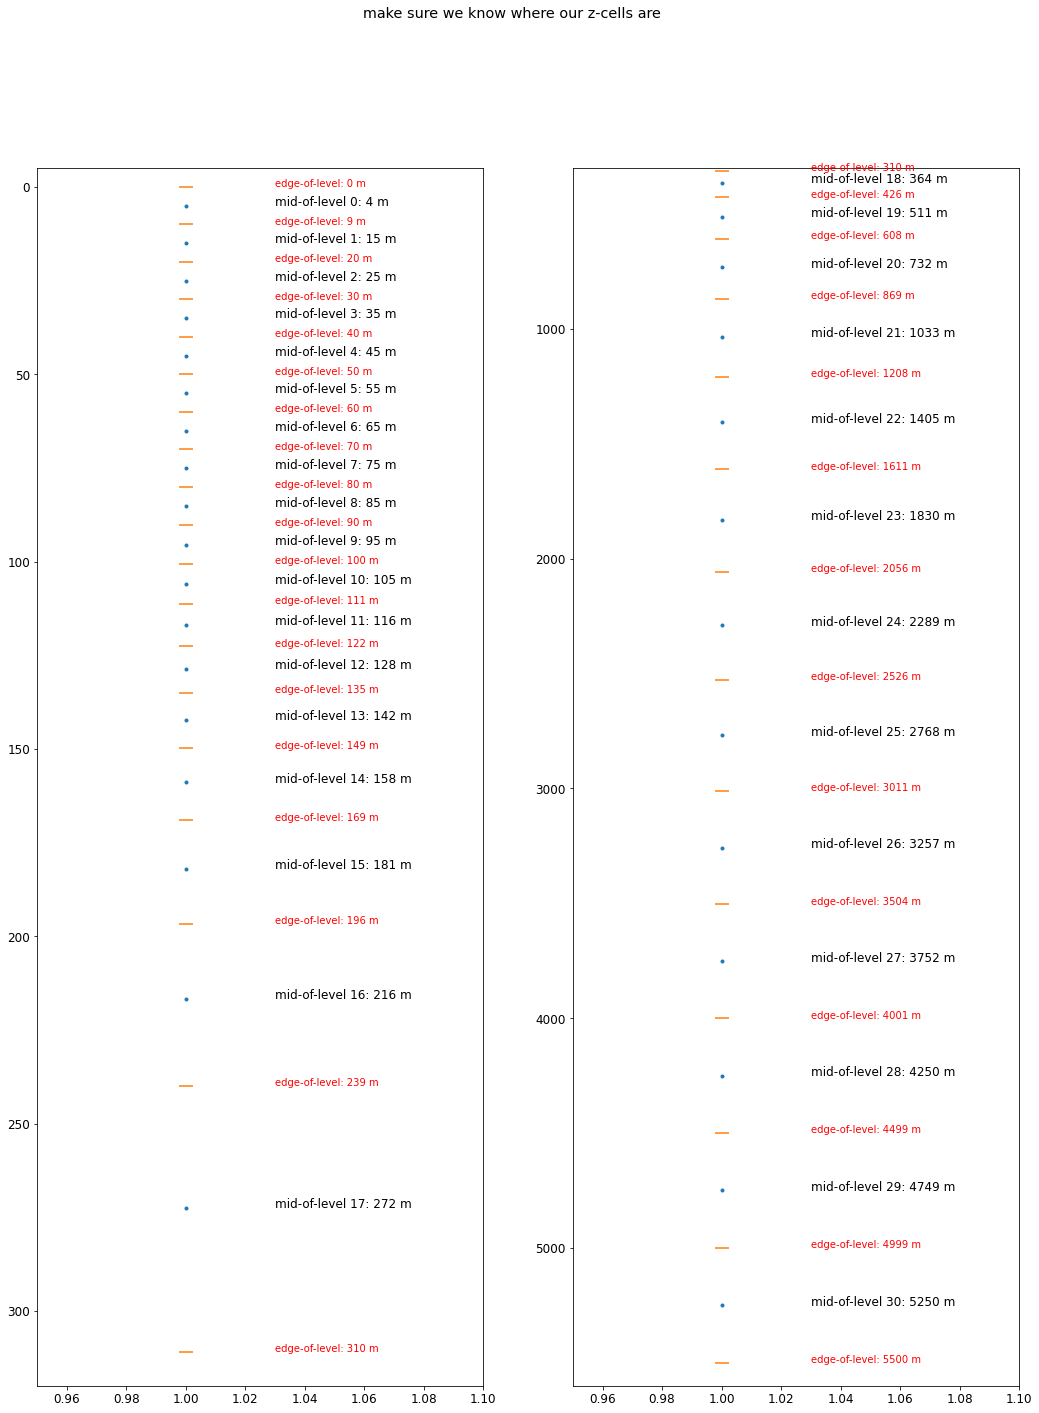

In [109]:
cellsizes_T = (tmesh['e3t_1d'][0,:])
middepths_T = (tmesh['gdept_1d'][0,:])
cellboundaries_T = np.zeros([32])
dots = np.zeros_like(middepths_T); dots[:] = 1
dots_bd = np.zeros_like(cellboundaries_T); dots_bd[:] = 1
for i in range(1,32):
    ind = i-1
    cellboundaries_T[i] = np.nansum(cellsizes_T[0:i])
fig = plt.figure(figsize=[22*fact, 28*fact])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(dots, middepths_T, marker = '.')
ax.scatter(dots_bd, cellboundaries_T, marker = '_', s = 200)

cutoff = 18; cutoffd = 320
for i in range(0,cutoff):
    td = int(middepths_T[i])
    ax.text(1.03, middepths_T[i], f'mid-of-level {i}: {td} m')
for i in range(0,cutoff+1):
    td = int(cellboundaries_T[i])
    ax.text(1.03, cellboundaries_T[i], f'edge-of-level: {td} m', fontsize = 10, color = 'r')
ax.set_ylim([-5,cutoffd])
ax.set_xlim([0.95,1.1])
ax.invert_yaxis()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(dots, middepths_T, marker = '.')
ax.scatter(dots_bd, cellboundaries_T, marker = '_', s = 200)
for i in range(cutoff,31):
    td = int(middepths_T[i])
    ax.text(1.03, middepths_T[i], f'mid-of-level {i}: {td} m')
for i in range(cutoff,32):
    td = int(cellboundaries_T[i])
    ax.text(1.03, cellboundaries_T[i], f'edge-of-level: {td} m', fontsize = 10, color = 'r')
ax.set_ylim([300,5600])
ax.set_xlim([0.95,1.1])
ax.invert_yaxis()
plt.suptitle('make sure we know where our z-cells are')

## write a function for getting level back - overly descriptive 
check it including edge cases

In [110]:

def get_zlevel_tgrid(depth, verbose = False):
    tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    cellsizes_T = (tmesh['e3t_1d'][0,:])
    middepths_T = (tmesh['gdept_1d'][0,:])
    #find cell boundaries based on grid
    cellboundaries_T = np.zeros([32])
    for i in range(1,32):
        cellboundaries_T[i] = np.nansum(cellsizes_T[0:i])

    if depth <= 0:
        tlev = 0
        
    elif depth > 5300:
        tlev = 30
    else:
        w = np.min(cellboundaries_T[cellboundaries_T>depth])
        tlev = int(np.where(cellboundaries_T == w)[0]) -1
        
    if verbose:
        print(f'for observation at depth {depth}, level found is {tlev}, nominal depth {middepths_T[tlev]}')
        print(f'boundaries of this level are {cellboundaries_T[tlev]}, {cellboundaries_T[tlev+1]}')
        print()
    return tlev

tlev = get_zlevel_tgrid(-5, verbose = True)
tlev = get_zlevel_tgrid(0, verbose = True)
tlev = get_zlevel_tgrid(40, verbose = True)
tlev = get_zlevel_tgrid(4000, verbose = True)
tlev = get_zlevel_tgrid(10000, verbose = True)

for observation at depth -5, level found is 0, nominal depth 4.9999377993644885
boundaries of this level are 0.0, 9.999999999996987

for observation at depth 0, level found is 0, nominal depth 4.9999377993644885
boundaries of this level are 0.0, 9.999999999996987

for observation at depth 40, level found is 3, nominal depth 35.00541279976915
boundaries of this level are 30.003111409005925, 40.00842461253802

for observation at depth 4000, level found is 27, nominal depth 3752.442203340017
boundaries of this level are 3504.2900219263747, 4001.0732369854973

for observation at depth 10000, level found is 30, nominal depth 5250.2266127632065
boundaries of this level are 4999.977208862945, 5500.541839849395



In [111]:
if horse:
    t_Z = np.zeros_like(depths)
    for i in range(0,len(t_Z)):
        t_Z[i] = get_zlevel_tgrid(depths[i])
        
df['mod_Y'] = mod_Y
df['mod_X'] = mod_X
df['mod_Z'] = t_Z
df.head()
df.to_csv('CAELsedimentObsMappedToModelGrid.csv')

# load snapped-to-grid cael dataset
# check which points are on land, plot results

7159 points total in dataset
6264 are in water according to the nemo grid
442 are straight-up on land (no ocean there)
453 are at xs and ys where water exists, but at a z that is land (so 'too deep' according to model bathymetry'

In [136]:
df = pd.read_csv('CAELsedimentObsMappedToModelGrid.csv')
df.head()
tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmask = tmesh['tmask'][0,:,:,:] 

mod_Y = df['mod_Y'].values
mod_X = df['mod_X'].values
t_Z = df['mod_Z'].values
inwater = np.zeros_like(t_Z)
water_at_level0 = np.zeros_like(t_Z)
for i in range(0,len(t_Z)):

    inwater[i] = tmask[int(t_Z[i]),int(mod_Y[i]),int(mod_X[i])] #at depth corr. to obs, do we map to land or water
    water_at_level0[i] = tmask[0,int(mod_Y[i]),int(mod_X[i])] #at level 0, do we map to land or water

array([1, 1, 1, ..., 1, 1, 1])

In [120]:
print(mod_X[(inwater==1) & (water_at_level0==0)])

[]


Of 7159 observations, 895 map to land using the imperfect orca grid



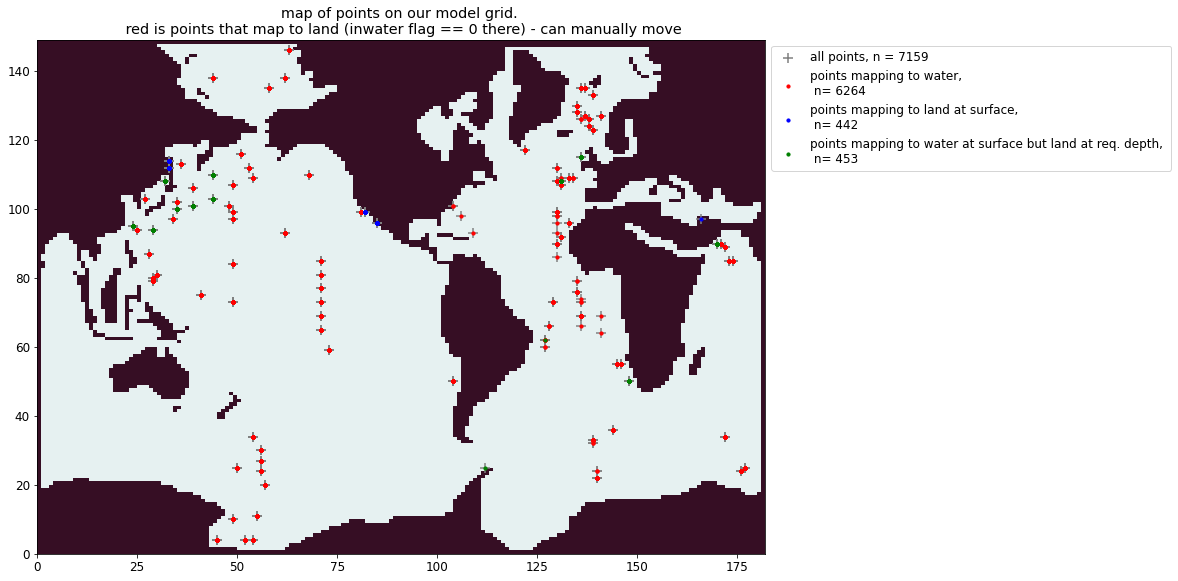

In [162]:
## water mask, when 1, in water
tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmask = tmesh['tmaskutil'][0,:,:] 



fact = 0.9
plt.figure(figsize=[14.5*fact, 10.5*fact])
plt.pcolormesh(tmask, vmin = 0, vmax = 1, cmap = cm.dense_r)
plt.scatter(mod_X, mod_Y, \
            s = 100, marker = '+',\
            color = 'grey', label = f'all points, n = {np.size(mod_X)}')
plt.scatter(mod_X[inwater==1], mod_Y[inwater==1], \
            s = 10, color = 'r', label = f'points mapping to water, \n n= {np.size(mod_X[inwater==1])}')
plt.scatter(mod_X[water_at_level0==0], mod_Y[water_at_level0==0], \
            s = 10, color = 'b', label = f'points mapping to land at surface, \n n= {np.size(mod_X[water_at_level0==0])}')
wat_at_surface_not_here = (water_at_level0==1) & (inwater == 0)
plt.scatter(mod_X[wat_at_surface_not_here], mod_Y[wat_at_surface_not_here], \
            s = 10, color = 'g', \
           label = f'points mapping to water at surface but land at req. depth, \n n= {np.size(mod_X[wat_at_surface_not_here])}')

plt.title('map of points on our model grid. \n red is points that map to land (inwater flag == 0 there) - can manually move')

onland = len(inwater[inwater == 0])
total = len(inwater)
plt.legend(bbox_to_anchor = [1,1])
print(f'Of {total} observations, {onland} map to land using the imperfect orca grid')
print()

In [154]:
on_land = np.zeros_like(inwater)
on_land[inwater == 0] = 1 

on_land_bc_too_deep = np.zeros_like(t_Z)
on_land_bc_too_deep[wat_at_surface_not_here] = 1

on_land_at_surface = np.zeros_like(t_Z)
on_land_at_surface[(water_at_level0==0)] = 1

print('points on land total')
print(np.size(on_land[on_land ==1]))
print('points whose surface at this XY is in water but who are on land at this depth')
print(np.size(on_land_bc_too_deep[on_land_bc_too_deep ==1]))
print('points who are on land on the surface (and therefore also at this depth')
print(np.size(on_land_at_surface[on_land_at_surface ==1]))


points on land total
895
points whose surface at this XY is in water but who are on land at this depth
453
points who are on land on the surface (and therefore also at this depth
442


In [155]:
df['on_land'] = on_land
df['on_land_at_surface'] = on_land_at_surface
df['on_land_bc_too_deep'] = on_land_bc_too_deep
df.head()
df.to_csv('CAELsedimentObsMappedToModelGrid_withlandflags.csv')

In [157]:
rslt_df = df[df['on_land_bc_too_deep'] == 1]

(array([120.,  30.,  20.,  21.,   0.,  78.,  21.,   0.,  34., 129.]),
 array([1000., 1409., 1818., 2227., 2636., 3045., 3454., 3863., 4272.,
        4681., 5090.]),
 <BarContainer object of 10 artists>)

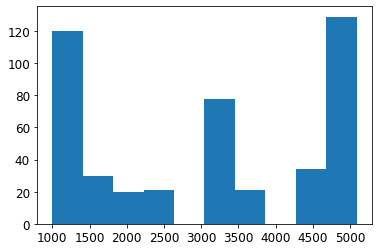

In [160]:
plt.hist(rslt_df['depth'].values)

(7159,)